In [35]:
import sys, os 
sys.path.append("..") 

In [36]:
import pfb 
import numpy as np 
from constants import SINC,LBLOCK,NTAP 
from numpy.fft import fft,rfft,ifft,irfft 
import matplotlib.pyplot as plt 

In [38]:
def A(x): 
    b = pfb.forward_pfb(x) 
    b = irfft(b) 
    b = np.concatenate([b , b[:3,:]],axis=0) 
    return b.flatten() 

def A_inv(b_flat,lblock=LBLOCK): 
    if len(b_flat)/lblock != len(b_flat)//lblock: raise Exception("the dimensions of the input does not match lblock:\n\
        {} should be an integer".format(len(b_flat)/lblock)) 
    b = np.array([b_flat[i*lblock:(i+1)*lblock] for i in range(k-3)]) # -3 drops the last three rows
    b = rfft(b) 
    return pfb.inverse_pfb(b) 

def A_quantize(x,delta=0.1): # delta is the quantization interval 
    b = pfb.forward_pfb(x) 
    b = pfb.quantize( b , np.sqrt(2*(b.shape[1] - 1)) * delta ) # quantize the pfb 
    b = irfft(b) # same as apply along axis=1
    b = np.concatenate([b , b[:3,:]],axis=0) 
    return b.flatten() 

def R(x,lblock=LBLOCK): 
    lx = len(x) 
    if lx/lblock != lx//lblock: 
        raise Exception("len x={} is not divisible by lblock={}".format(lx,lblock)) 
    k = lx // lblock 
    out = np.zeros(lx) 
    for i in range(k): 
        out[lblock*i:lblock*(i+1)] = x[lblock*(k-i-1):lblock*(k-i)] 
    return out 

def AT(x): # the transpose of A
    return R(A(R(x)))


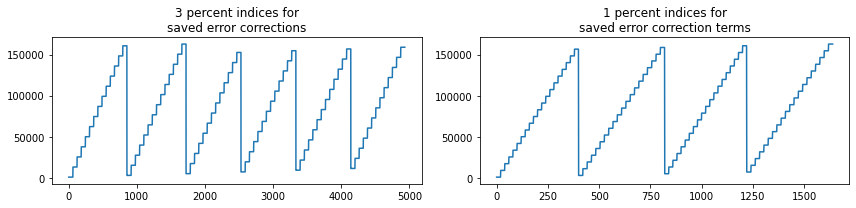

In [39]:
k = 80 # number of blocks (frames in chimeland) about 15 million

def get_saved_idxs_3_percent(n_per_save=5,k=80):
    # returns 3% of indices of most troublesome elements in TS
    LBLOCK = 2048
    n_pix_3perc = 31616 # the number of pixels in eigenvalue plot that we're allowed
    height_3 = 515 // n_per_save
    width_3 = n_pix_3perc // height_3
    saved_data_3perc = np.arange(LBLOCK//2 - width_3//2, LBLOCK//2 + width_3//2) # width
    pices = [saved_data_3perc[(i*width_3)//n_per_save:((i+1)*width_3)//n_per_save] for i in range(n_per_save)]
    saved_idxs_3 = np.concatenate([
        np.concatenate(
            [pices[s] + s*LBLOCK + i*n_per_save*LBLOCK for i in range((k+n_per_save-s-1)//n_per_save)]
        ) for s in range(n_per_save)
    ])
    return width_3 , saved_idxs_3

def get_saved_idxs_1_percent(n_per_save=4,k=80):
    # returns 1% of indices of TS
    LBLOCK = 2048
    n_pix_1perc = 10542 # the number of pixels in eigenvalue plot that we're allowed (heigh 151)
    height_1 = 515 // n_per_save
    width_1 = n_pix_1perc // height_1
    saved_data_1perc = np.arange(LBLOCK//2 - width_1//2, LBLOCK//2 + width_1//2) 
    pices = [saved_data_1perc[(i*width_1)//n_per_save:((i+1)*width_1)//n_per_save] for i in range(n_per_save)]
    saved_idxs_1 = np.concatenate([
        np.concatenate(
            [pices[s] + s*LBLOCK + i*n_per_save*LBLOCK for i in range((k+n_per_save-s-1)//n_per_save)]
        ) for s in range(n_per_save)
    ])
    return width_1 , saved_idxs_1 

width_3 , saved_idxs_3 = get_saved_idxs_3_percent(n_per_save=6 , k=k) 
width_1 , saved_idxs_1 = get_saved_idxs_1_percent(n_per_save=4 , k=k)


plt.subplots(figsize=(12,3))
plt.subplot(121)
plt.plot(saved_idxs_3)
plt.title("3 percent indices for\nsaved error corrections")

plt.subplot(122)
plt.plot(saved_idxs_1)
plt.title("1 percent indices for\nsaved error correction terms")

plt.tight_layout()
plt.show()

In [40]:
def conjugate_gradient_descent(B,u,x0=None,rmin=0.1,max_iter=100): 
    # u is the data, B is the symmetric matrix operator (written as func)
    # solve for x : Bx = u
    if type(x0) != np.ndarray: x0 = np.zeros(len(u)) # if x0 is None basically
    x = x0.copy()
#     print("Input")
#     print("\n\nx0={}".format(x)) 
#     print("\n\nu={}".format(u))
    r = u - B(x0)
    if np.sqrt(np.dot(r,r)) < rmin:
#         print("Initial value already close enough to target value, no need for gradient descent.")
        return x
    p = r.copy()
    for i in range(max_iter): 
        Bp = B(p)
        alpha = np.dot(r,r) / np.dot(p,Bp)
        x = x + alpha * p
        r_new = r - alpha * Bp
#         print("({}) |r| = {}".format(i,np.sqrt(np.dot(r,r))))
        if np.sqrt(np.dot(r,r)) < rmin:
#             print("terminating after {} iterations,\n\
#                 remainder smaller than minimum value {}".format(i,rmin))
            break
        beta = np.dot(r_new,r_new) / np.dot(r,r)
        p = r_new + beta * p
        r = r_new
#     print("conjugate gradient computed") 
#     print("\n\nx_out={}".format(x)) 
    return x

In [41]:
def simulate_quantization_error( delta=0.05 , n_sims = 100 , k=60 ):
    # input param delta is the quantization step
    x_arr = [] # list of input timestream arrays
    x0_arr = [] # list of IPFB output arrays
    x1_perc_arr = [] # list of reconstructed arrays with 1% extra data
    x3_perc_arr = [] # list of reconstructed arrays with 3% extra data
    for sim in range(n_sims):
        print(sim,end=" ")
        x = np.random.normal(0,1,LBLOCK*k) 

        d = A_quantize(x,delta)
        # N_inv and Q_inv are diagonal matrices so we store them as 1D-arrays
        N_inv = np.ones(len(x)) * 6 / delta**2

        ### 3 percent of original data given as prior
        # the noise matrix for the prior
        prior_3 = np.zeros(len(x)) # what we know about x, information we saved
        prior_3[saved_idxs_3] = pfb.quantize_real(x[saved_idxs_3].copy() , delta) # quantized original signal
        
        Q_inv_3 = np.zeros(len(x)) # infinite uncertainty cause we don't know them
        Q_inv_3[saved_idxs_3] = np.ones(len(saved_idxs_3)) * 12 / delta**2 # 8 bits per real number (finer std because no complex)
        
        B_3 = lambda ts: AT(N_inv * A(ts)) + Q_inv_3 * ts # think ts===x
        u_3 = AT(N_inv * d) + Q_inv_3 * prior_3 # this is same as mult prior by var=12/delta^2
        
        ### 1 percent of original data given as prior
        # the noise matrix for the prior
        prior_1 = np.zeros(len(x)) # what we know about x, information we saved
        prior_1[saved_idxs_1] = pfb.quantize_real(x[saved_idxs_1].copy() , delta) # quantized original signal

        Q_inv_1 = np.zeros(len(x)) 
        Q_inv_1[saved_idxs_1] = np.ones(len(saved_idxs_1)) * 12 / delta**2 # 8 bits per real number

        B_1 = lambda ts: AT(N_inv * A(ts)) + Q_inv_1 * ts # think ts===x
        u_1 = AT(N_inv * d) + Q_inv_1 * prior_1

        ### Optimize CHI squared using conjugate gradient method
        # x0 is the standard IPFB reconstruction
        x0 = np.real( A_inv(d) )
        # indices to set to zero when initializing reconstruction (because errors blow up at these indices)
        zero_idxs = np.concatenate([np.arange(LBLOCK // 2 - 200+1 + i*LBLOCK , LBLOCK // 2 + 200+1 + i*LBLOCK) for i in range(k)])
        x0_with_zeros = x0.copy()
        x0_with_zeros[zero_idxs] = np.zeros(len(zero_idxs))
        # print("\n\nd={}".format(d)) # trace, they are indeed real
        # print("\n\nx_0={}".format(x0)) # complex dtype but zero imag componant

#         print("\nConjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)")
        x_out_3 = conjugate_gradient_descent(B_3,u_3,x0=x0_with_zeros,rmin=1000,max_iter=30)
#         print("\n\n-----------------------------------------------------------------------------------------------")
#         print("-----------------------------------------------------------------------------------------------")
#         print("\n\n\nConjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)")
        x_out_1 = conjugate_gradient_descent(B_1,u_1,x0=x0_with_zeros,rmin=2000,max_iter=35)
        
        # save the arrays
        x_arr.append(x)
        x0_arr.append(x0) 
        x1_perc_arr.append(x_out_1)
        x3_perc_arr.append(x_out_3)
    return np.array(x_arr), np.array(x0_arr), np.array(x1_perc_arr), np.array(x3_perc_arr)

In [42]:
delta = 0.1

In [56]:
# run the simulation a WHOLE bunch of times for different width / height ratios to determine what is best
delta = 0.1
rmse_3_perc_arr = []
# for n_per_save in range(4,9):
#     width_3 , saved_idxs_3 = get_saved_idxs_3_percent(n_per_save= n_per_save)
    
#     x_arr, x0_arr, x1_perc_arr, x3_perc_arr = simulate_quantization_error(delta , n_sims=250 , k=k)
#     # estimate the RMS errors
#     rmse_3_perc = np.sqrt( np.mean((x3_perc_arr - x_arr)**2, axis=0) ) 
#     rmse_3_perc_arr.append(rmse_3_perc)
    
rmse_3_perc_arr = [] 
rmse_1_perc_arr = [] 
for n_per_save in range(9,13):
    width_1 , saved_idxs_1 = get_saved_idxs_1_percent(n_per_save= n_per_save)
    width_3 , saved_idxs_3 = get_saved_idxs_3_percent(n_per_save= n_per_save)

    
    x_arr, x0_arr, x1_perc_arr, x3_perc_arr = simulate_quantization_error(delta , n_sims=1000 , k=k)
    # estimate the RMS errors
    rmse_1_perc = np.sqrt( np.mean((x1_perc_arr - x_arr)**2, axis=0) ) 
    rmse_1_perc_arr.append(rmse_1_perc)
    rmse_3_perc = np.sqrt( np.mean((x3_perc_arr - x_arr)**2, axis=0) ) 
    rmse_3_perc_arr.append(rmse_3_perc)
    
np.save("rmse_1_perc_9to12.npy",np.array(rmse_1_perc_arr))
np.save("rmse_3_perc_9to12.npy",np.array(rmse_3_perc_arr))
    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 

In [16]:
x_arr, x0_arr ,_,_ = simulate_quantization_error(0.1 , n_sims=250 , k=k)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 

In [44]:
rmse_ipfb = np.sqrt(((x_arr - x0_arr)**2).mean(axis=0) )

In [61]:
# np.save("rmse_1_perc_2to8_aaa.npy",np.array(rmse_1_perc_arr))
# np.save("rmse_3_perc_2to8_aaa.npy",np.array(rmse_3_perc_arr))

# rmse_1_perc_arr_28 = np.load("rmse_1_perc_2to8.npy")
# rmse_3_perc_arr_28 = np.load("rmse_3_perc_2to8.npy")
# rmse_1_perc_arr_912 = np.load("rmse_1_perc_9to12.npy")
# rmse_3_perc_arr_912 = np.load("rmse_3_perc_9to12.npy")
# rmse_1_perc_arr = np.concatenate([rmse_1_perc_arr_28,rmse_1_perc_arr_912],axis=0)
# rmse_3_perc_arr = np.concatenate([rmse_3_perc_arr_28,rmse_3_perc_arr_912],axis=0)
# np.save("rmse_1_perc_2to12_aaa.npy",rmse_1_perc_arr)
# np.save("rmse_3_perc_2to12_aaa.npy",rmse_3_perc_arr)

rmse_1_perc_arr = np.load("rmse_1_perc_2to12.npy")
rmse_3_perc_arr = np.load("rmse_3_perc_2to12.npy")

In [46]:
# delta = 0.1
# x_arr, x0_arr, x1_perc_arr, x3_perc_arr = simulate_quantization_error(delta , n_sims=250 , k=k)

# # estimate the RMS errors
# rmse_ipfb = np.sqrt( np.mean((x0_arr - x_arr)**2, axis=0) )
# rmse_1_perc = np.sqrt( np.mean((x1_perc_arr - x_arr)**2, axis=0) )
# rmse_3_perc = np.sqrt( np.mean((x3_perc_arr - x_arr)**2, axis=0) )

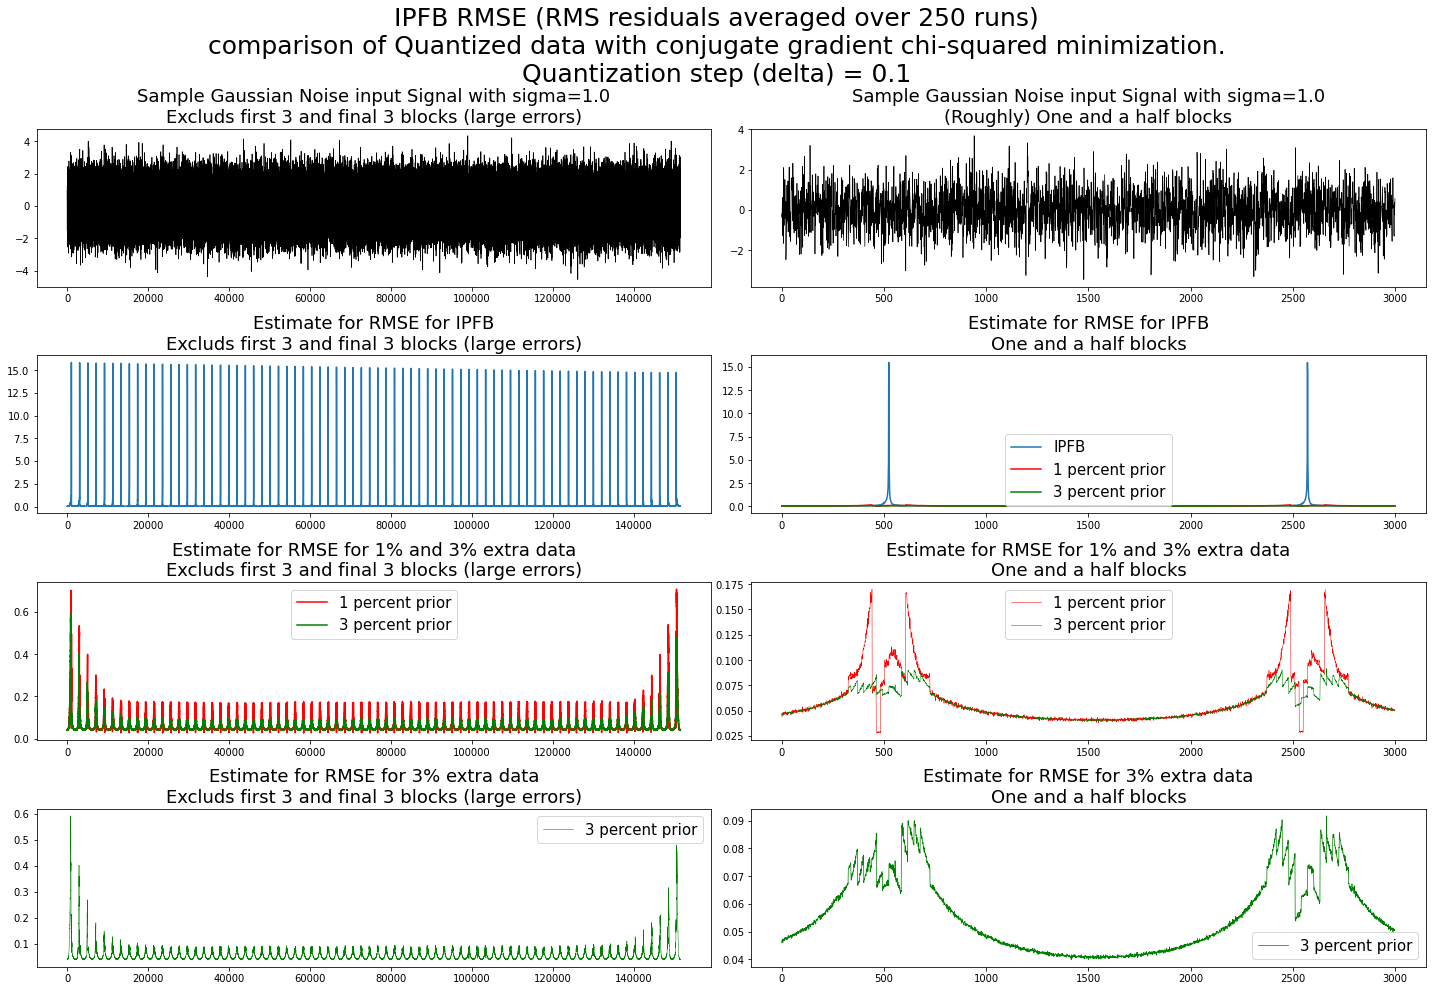

In [47]:
# idx1 = np.arange(2*LBLOCK,20*LBLOCK) 
idx1 = np.arange(3*LBLOCK,len(x_arr[0]) - 3*LBLOCK)
idx2 = np.arange(51700,54700) 

plt.subplots(figsize=(20,14))
plt.subplot(421)
plt.title("Sample Gaussian Noise input Signal with sigma=1.0\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18)
plt.plot(x_arr[0][idx1],linewidth=0.7,color="k")

plt.subplot(422)
plt.title("Sample Gaussian Noise input Signal with sigma=1.0\n(Roughly) One and a half blocks",fontsize=18)
plt.plot(x_arr[0][idx2],linewidth=0.7,color="k")

plt.subplot(423) 
plt.title("Estimate for RMSE for IPFB\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18) 
plt.plot(rmse_ipfb[idx1]) 

plt.subplot(424) 
plt.title("Estimate for RMSE for IPFB\nOne and a half blocks",fontsize=18) 
plt.plot(rmse_ipfb[idx2],label="IPFB") 
plt.plot(rmse_1_perc[idx2],color="red",label="1 percent prior") 
plt.plot(rmse_3_perc[idx2],color="green",label="3 percent prior") 
plt.legend(fontsize=15) 

plt.subplot(425) 
plt.title("Estimate for RMSE for 1% and 3% extra data\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18) 
plt.plot(rmse_1_perc[idx1],color="red",label="1 percent prior") 
plt.plot(rmse_3_perc[idx1],color="green",label="3 percent prior")
plt.legend(fontsize=15)

plt.subplot(426) 
plt.title("Estimate for RMSE for 1% and 3% extra data\nOne and a half blocks",fontsize=18) 
plt.plot(rmse_1_perc[idx2],color="red",linewidth=0.5,label="1 percent prior") 
plt.plot(rmse_3_perc[idx2],color="green",linewidth=0.5,label="3 percent prior")
plt.legend(fontsize=15)

plt.subplot(427) 
plt.title("Estimate for RMSE for 3% extra data\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18) 
plt.plot(rmse_3_perc[idx1],color="green",linewidth=0.5,label="3 percent prior") 
plt.legend(fontsize=15) 

plt.subplot(428) 
plt.title("Estimate for RMSE for 3% extra data\nOne and a half blocks",fontsize=18) 
plt.plot(rmse_3_perc[idx2],color="green",linewidth=0.7,label="3 percent prior") 
plt.legend(fontsize=15) 


plt.suptitle("IPFB RMSE (RMS residuals averaged over 250 runs)\n\
comparison of Quantized data with conjugate gradient chi-squared minimization.\n\
Quantization step (delta) = {}".format(delta),fontsize=25) 

plt.tight_layout() 

plt.savefig("rmse_ipfb_quantization_delta={:.2f}.png".format(delta)) 

plt.show() 

In [48]:
delta / np.sqrt(12) # sanity check for plots above, the RMSE should never be below that

0.02886751345948129

magenta


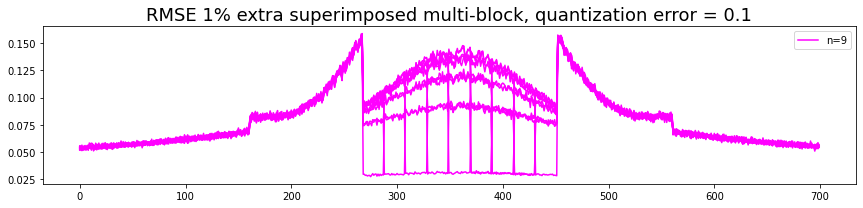

In [106]:
idx2_0 = 66200 # + LBLOCK//2
idx2 = np.arange(idx2_0,idx2_0 + 700) 


plt.subplots(figsize=(12,3))
# plt.subplot(211)
plt.title("RMSE 1% extra superimposed multi-block, quantization error = {}".format(delta),fontsize=18)
colors = ["blue","red","green","black","orange","cyan","brown","magenta","violet","indigo","yellow"]
ns = [9]
for n in ns:
    rmse_1_perc = rmse_1_perc_arr[n-2]
    print(colors[n-2])
    plt.plot(rmse_1_perc[idx2],color=colors[n-2],label="n={}".format(n))
    for i in range(1,12):
        plt.plot(rmse_1_perc[idx2+i*LBLOCK],color=colors[n-2])
plt.legend()

# plt.subplot(212)
# plt.title("rmse 1% mean")
# for n in ns:
#     rmse_1_perc = rmse_1_perc_arr[n-2]
#     rmse_1_perc_mean = np.mean(np.array([rmse_1_perc[idx2+i*LBLOCK] for i in range(-4,12)]),axis=0)
#     plt.plot(rmse_1_perc_mean,color=colors[n-2],label="n={}".format(n))
# plt.legend()


plt.tight_layout()
plt.savefig("RMSE_superimposed_multi_block_1perc.png")
plt.show()



orange


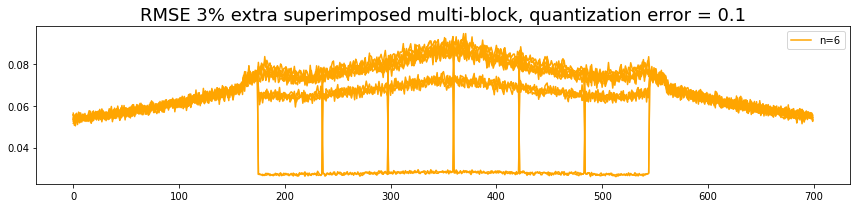

In [114]:

idx2_0 = 66200
idx2 = np.arange(idx2_0,idx2_0 + 700) 


plt.subplots(figsize=(12,3))
# plt.subplot(211)
plt.title("RMSE 3% extra superimposed multi-block, quantization error = {}".format(delta),fontsize=18)
colors = ["blue","red","green","black","orange","cyan","brown","magenta","violet","indigo","yellow"]
ns = [6]
for n in ns:
    rmse_3_perc = rmse_3_perc_arr[n-2]
    print(colors[n-2])
    plt.plot(rmse_3_perc[idx2],color=colors[n-2],label="n={}".format(n))
    for i in range(1,12):
        plt.plot(rmse_3_perc[idx2+i*LBLOCK],color=colors[n-2])
plt.legend()

# plt.subplot(212)
# plt.title("rmse 3% mean")
# for n in ns:
#     rmse_3_perc = rmse_3_perc_arr[n-2]
#     rmse_3_perc_mean = np.mean(np.array([rmse_3_perc[idx2+i*LBLOCK] for i in range(-4,12)]),axis=0)
#     plt.plot(rmse_3_perc_mean,color=colors[n-2],label="n={}".format(n))
# plt.legend()


plt.tight_layout()
# plt.savefig("RMSE_superimposed_multi_block_3perc_aaa.png")
plt.show()

